In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

import sys
sys.path.append("../../../")
from gradboost_pv.models.basic import load_local_preprocessed_slice, build_datasets_from_local
from gradboost_pv.models.utils import linear_trend_estimation

In [4]:
# nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_4.zarr/"
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_4/UKV_intermediate_version_3.zarr"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [5]:
_slice = load_local_preprocessed_slice(0)

In [6]:
X, y = build_datasets_from_local(_slice, gsp, nwp.coords["step"].values[0])

In [37]:
from numba import jit

@jit
def linear_trend_estimation(data: np.ndarray, epsilon=0.01):
    # assert all(["x" in data.columns, "y" in data.columns])
    _x, _y = data[:, 0], data[:, 1]
    return max(min((1 / ((_x.dot(_x) + epsilon)) * (_x.dot( _y)), 10), -10))
    return [np.mean(data[:, 0]), 1]


In [38]:
X.rename(columns={"h": "x", "t": "y"})[["x", "y"]].rolling(window=10, method="table").apply(linear_trend_estimation, raw=True, engine="numba")

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of type(CPUDispatcher(<function linear_trend_estimation at 0x7f03e4596320>)) with parameters (array(float64, 2d, A))

During: resolving callee type: type(CPUDispatcher(<function linear_trend_estimation at 0x7f03e4596320>))
During: typing of call at /home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/pandas/core/window/numba_.py (230)


File "../../../../../mambaforge/envs/xg_pv/lib/python3.10/site-packages/pandas/core/window/numba_.py", line 230:
    def roll_table(
        <source elided>
            count_nan = np.sum(np.isnan(window), axis=0)
            sub_result = numba_func(window, *args)
            ^


In [7]:
X

,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,...,prate,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR,PV_LAG_1HR,PV_LAG_DAY,AR_Beta
2020-01-02 00:00:00,1830.295410,68.563416,19.307510,57.356369,0.001268,-32629.847656,-1.387779e-17,327.078430,2799.174805,281.223633,...,0.000023,0.5,0.866025,0.034328,0.999411,0.000000,1.000000,0.000000,0.000000,0.000000
2020-01-02 00:30:00,1790.093502,69.308458,19.208619,57.773155,0.001267,-32575.436708,8.542924e-03,327.614548,2793.197986,281.260836,...,0.000026,0.5,0.866025,0.034328,0.999411,0.130526,0.991445,0.000000,0.000000,0.000000
2020-01-02 01:00:00,1760.556813,69.979910,18.987266,58.022370,0.001267,-32491.071482,3.179243e-02,328.079769,2787.651967,281.299013,...,0.000028,0.5,0.866025,0.034328,0.999411,0.258819,0.965926,0.000000,0.000000,0.000000
2020-01-02 01:30:00,1739.822385,70.567550,18.732150,58.152346,0.001266,-32370.724761,5.615571e-02,328.487383,2781.596403,281.337749,...,0.000030,0.5,0.866025,0.034328,0.999411,0.382683,0.923880,0.000000,0.000000,0.000000
2020-01-02 02:00:00,1726.027262,71.061156,18.531970,58.211415,0.001265,-32208.369325,6.803994e-02,328.850674,2774.090949,281.376628,...,0.000033,0.5,0.866025,0.034328,0.999411,0.500000,0.866025,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 13:00:00,1506.390751,64.635937,52.425588,55.233770,0.000025,-32629.864650,1.164639e+02,346.732082,3121.229402,284.948535,...,0.000043,-0.5,0.866025,0.136906,0.990584,-0.258819,-0.965926,0.233525,0.318703,1.308326
2021-11-08 13:30:00,1459.914016,65.062383,53.152989,55.220780,0.000025,-32629.869164,1.059529e+02,347.436060,3117.175423,285.026305,...,0.000041,-0.5,0.866025,0.136906,0.990584,-0.382683,-0.923880,0.221520,0.273910,1.289124
2021-11-08 14:00:00,1404.634326,65.555342,54.093611,54.979213,0.000025,-32629.868898,8.974394e+01,348.004202,3108.765539,285.047827,...,0.000042,-0.5,0.866025,0.136906,0.990584,-0.500000,-0.866025,0.191085,0.220691,1.212733
2021-11-08 14:30:00,1341.477141,66.105792,55.259969,54.463322,0.000025,-32629.862260,6.723741e+01,348.401999,3095.530420,285.003983,...,0.000046,-0.5,0.866025,0.136906,0.990584,-0.608761,-0.793353,0.159681,0.177553,1.101661


In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.01,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 50,
               'max_leaves': 0,
               'min_child_weight': 20,
               'n_estimators': 1500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.85,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
                   ) -> ExperimentSummary:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )
        

In [7]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    _slice = load_local_preprocessed_slice(step)
    X, y = build_datasets_from_local(_slice, gsp, nwp.coords["step"].values[step])
    output = run_experiment(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


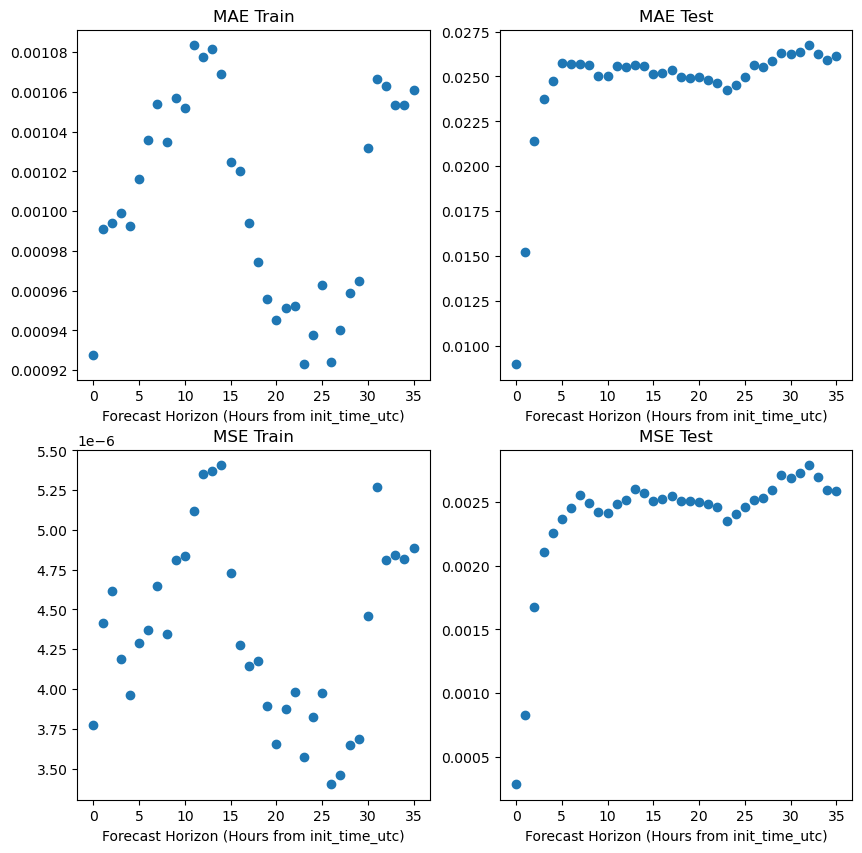

In [8]:
# plot the MAE of the OOS for each model
from typing import Dict

def plot_loss_metrics(results_by_fh: Dict[int, ExperimentSummary]):
    title_mapping = {"MAE Train": lambda x: x.mae_train_loss,
                     "MAE Test": lambda x: x.mae_test_loss,
                     "MSE Train": lambda x: x.mse_train_loss,
                     "MSE Test": lambda x: x.mse_test_loss}
    
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    
    for idx, title in enumerate(title_mapping.keys()):
        row = int(idx > 1)
        col = idx % 2
        data = pd.Series({step: title_mapping[title](r) for step, r in results_by_fh.items()})
        axes[row][col].scatter(data.index, data.values)
        axes[row][col].set_title(title)
        axes[row][col].set_xlabel("Forecast Horizon (Hours from init_time_utc)")

plot_loss_metrics(results)

In [4]:
from gradboost_pv.models.utils import ORDERED_NWP_FEATURE_VARIABLES

X = pd.DataFrame(data=_slice.reshape(_slice.shape[1], _slice.shape[2]).T, index=gsp.coords["datetime_gmt"].values, columns=ORDERED_NWP_FEATURE_VARIABLES)

In [22]:
X


,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,r,dpt,vis,si10,wdir10,prmsl,prate
2020-01-01 00:00:00,632.369995,70.870087,5.830586,32.670364,0.001283,-32629.847656,0.000000,316.232666,2688.883789,280.208954,85.932365,277.964325,15064.458008,6.881776,188.229904,102725.976562,0.000001
2020-01-01 00:30:00,687.646356,70.705035,5.433613,32.899234,0.001283,-32629.835099,-0.193904,315.983130,2702.628593,280.190395,85.942563,277.952649,14880.364175,6.862118,188.265013,102700.899462,0.000001
2020-01-01 01:00:00,742.721343,70.725728,5.330769,33.388923,0.001283,-32629.829391,-0.282043,316.028534,2710.335820,280.176540,85.968588,277.946975,14746.720178,6.856966,188.589163,102674.871755,0.000001
2020-01-01 01:30:00,797.380025,70.899727,5.482882,34.104579,0.001283,-32629.829162,-0.285568,316.322121,2712.813544,280.166897,86.008677,277.946697,14655.544720,6.864013,189.151146,102648.336949,0.000001
2020-01-01 02:00:00,851.407470,71.194592,5.850780,35.011349,0.001283,-32629.833044,-0.225634,316.817136,2710.869839,280.160970,86.061064,277.951208,14598.856503,6.880958,189.899750,102621.738550,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 13:00:00,1506.390751,64.635937,52.425588,55.233770,0.000025,-32629.864650,116.463900,346.732082,3121.229402,284.948535,83.848250,282.240042,16736.953173,6.910919,221.490776,101661.084446,0.000043
2021-11-08 13:30:00,1459.914016,65.062383,53.152989,55.220780,0.000025,-32629.869164,105.952857,347.436060,3117.175423,285.026305,83.854154,282.318850,16856.013534,6.996771,222.303429,101641.143742,0.000041
2021-11-08 14:00:00,1404.634326,65.555342,54.093611,54.979213,0.000025,-32629.868898,89.743944,348.004202,3108.765539,285.047827,84.073472,282.381354,16874.653570,7.072594,222.936996,101620.714499,0.000042
2021-11-08 14:30:00,1341.477141,66.105792,55.259969,54.463322,0.000025,-32629.862260,67.237410,348.401999,3095.530420,285.003983,84.544713,282.425687,16775.666540,7.135707,223.324433,101600.087789,0.000046


In [23]:
X2 = X.shift(freq=-shift)
X2

,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,r,dpt,vis,si10,wdir10,prmsl,prate
2019-12-31 23:00:00,632.369995,70.870087,5.830586,32.670364,0.001283,-32629.847656,0.000000,316.232666,2688.883789,280.208954,85.932365,277.964325,15064.458008,6.881776,188.229904,102725.976562,0.000001
2019-12-31 23:30:00,687.646356,70.705035,5.433613,32.899234,0.001283,-32629.835099,-0.193904,315.983130,2702.628593,280.190395,85.942563,277.952649,14880.364175,6.862118,188.265013,102700.899462,0.000001
2020-01-01 00:00:00,742.721343,70.725728,5.330769,33.388923,0.001283,-32629.829391,-0.282043,316.028534,2710.335820,280.176540,85.968588,277.946975,14746.720178,6.856966,188.589163,102674.871755,0.000001
2020-01-01 00:30:00,797.380025,70.899727,5.482882,34.104579,0.001283,-32629.829162,-0.285568,316.322121,2712.813544,280.166897,86.008677,277.946697,14655.544720,6.864013,189.151146,102648.336949,0.000001
2020-01-01 01:00:00,851.407470,71.194592,5.850780,35.011349,0.001283,-32629.833044,-0.225634,316.817136,2710.869839,280.160970,86.061064,277.951208,14598.856503,6.880958,189.899750,102621.738550,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 12:00:00,1506.390751,64.635937,52.425588,55.233770,0.000025,-32629.864650,116.463900,346.732082,3121.229402,284.948535,83.848250,282.240042,16736.953173,6.910919,221.490776,101661.084446,0.000043
2021-11-08 12:30:00,1459.914016,65.062383,53.152989,55.220780,0.000025,-32629.869164,105.952857,347.436060,3117.175423,285.026305,83.854154,282.318850,16856.013534,6.996771,222.303429,101641.143742,0.000041
2021-11-08 13:00:00,1404.634326,65.555342,54.093611,54.979213,0.000025,-32629.868898,89.743944,348.004202,3108.765539,285.047827,84.073472,282.381354,16874.653570,7.072594,222.936996,101620.714499,0.000042
2021-11-08 13:30:00,1341.477141,66.105792,55.259969,54.463322,0.000025,-32629.862260,67.237410,348.401999,3095.530420,285.003983,84.544713,282.425687,16775.666540,7.135707,223.324433,101600.087789,0.000046


In [32]:
X2.shift(freq=(shift + np.timedelta64(1, "h")))

,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,r,dpt,vis,si10,wdir10,prmsl,prate
2020-01-01 01:00:00,632.369995,70.870087,5.830586,32.670364,0.001283,-32629.847656,0.000000,316.232666,2688.883789,280.208954,85.932365,277.964325,15064.458008,6.881776,188.229904,102725.976562,0.000001
2020-01-01 01:30:00,687.646356,70.705035,5.433613,32.899234,0.001283,-32629.835099,-0.193904,315.983130,2702.628593,280.190395,85.942563,277.952649,14880.364175,6.862118,188.265013,102700.899462,0.000001
2020-01-01 02:00:00,742.721343,70.725728,5.330769,33.388923,0.001283,-32629.829391,-0.282043,316.028534,2710.335820,280.176540,85.968588,277.946975,14746.720178,6.856966,188.589163,102674.871755,0.000001
2020-01-01 02:30:00,797.380025,70.899727,5.482882,34.104579,0.001283,-32629.829162,-0.285568,316.322121,2712.813544,280.166897,86.008677,277.946697,14655.544720,6.864013,189.151146,102648.336949,0.000001
2020-01-01 03:00:00,851.407470,71.194592,5.850780,35.011349,0.001283,-32629.833044,-0.225634,316.817136,2710.869839,280.160970,86.061064,277.951208,14598.856503,6.880958,189.899750,102621.738550,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 14:00:00,1506.390751,64.635937,52.425588,55.233770,0.000025,-32629.864650,116.463900,346.732082,3121.229402,284.948535,83.848250,282.240042,16736.953173,6.910919,221.490776,101661.084446,0.000043
2021-11-08 14:30:00,1459.914016,65.062383,53.152989,55.220780,0.000025,-32629.869164,105.952857,347.436060,3117.175423,285.026305,83.854154,282.318850,16856.013534,6.996771,222.303429,101641.143742,0.000041
2021-11-08 15:00:00,1404.634326,65.555342,54.093611,54.979213,0.000025,-32629.868898,89.743944,348.004202,3108.765539,285.047827,84.073472,282.381354,16874.653570,7.072594,222.936996,101620.714499,0.000042
2021-11-08 15:30:00,1341.477141,66.105792,55.259969,54.463322,0.000025,-32629.862260,67.237410,348.401999,3095.530420,285.003983,84.544713,282.425687,16775.666540,7.135707,223.324433,101600.087789,0.000046
